# 297201 PROJECT 3: 
## Step 5: Training the Model
by: <rb>
Jonathan Tan, <br>
Seunghyeok Kang, <br>
John Lavack, 20001249

This code does:
1. Defines a function to train and evaluate any mode
2. Trains the data from step 4 on a variety of algorithm. 
3. The best algorithm is chosen manually
4. The best algorithm is hyper tuned
5. A function to create an input to the model is define and tested
6. the model is exported. 

In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import csv
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import log_loss,classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRegressor
import scipy.stats as stats
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings

warnings.filterwarnings('ignore')

# Training Models Function

In [3]:
def train_a_model(X, y, k, rs, mod ):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs,  test_size=0.2)

    model = mod
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
      
    #Cross validate
    #set the Kfold
    kf = KFold(n_splits = k, random_state=6, shuffle = True) 
    #do the cross validation
    scores = cross_val_score(model, X_test, y_test, cv=kf, scoring='accuracy', n_jobs = -1)
    #view mean absolute error
    MSEscores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error', cv=kf)
    MSE = np.round(abs(MSEscores.mean()),4)
    #view RMSE
    RMSEscores = cross_val_score(model, X_test, y_test, scoring='neg_mean_squared_error',cv=kf)
    RMSE = np.round(np.sqrt(abs(RMSEscores.mean())),4)

    conmat = confusion_matrix(y_test, predictions)
    val = np.mat(conmat) 
    classnames = list(set(y_train))
    df_cm = pd.DataFrame(val, index=classnames, columns=classnames)
    
    classifier = np.round(model.score(X_test, y_test),4)
    train_accuracy = np.round(model.score(X_test, y_test), 4)
    accuracy = np.round(accuracy_score(y_test, predictions), 4)
    precision = np.round(precision_score(y_test, predictions, average='macro'), 4)
    recall = np.round(recall_score(y_test, predictions, average='macro'), 4)
    f1 = np.round(f1_score(y_test, predictions, average='macro'), 4)
    AUROC = np.round(roc_auc_score(y_test, y_pred_proba[:,1]), 4)
    ll = log_loss(y_test, y_pred_proba)
    
    #----------------Print scores----------------------------------------------
    print("\n---------CLASSIFIER PERFORMANCE-------------------------------\n")
    print('       Classifier score: ', classifier)
    print("      Training Accuracy: ", train_accuracy)
    print("    Prediciton Accuracy: ", accuracy)
    print("              Precision: ", precision)
    print("                 Recall: ", recall)
    print("               F1 Score: ", f1)
    print("                  AUROC: ", AUROC)
    print("               Log Loss: ", ll)
    print("\n---------CROSS VALIDATION-------------------------------------\n")
    print(' Cross validated scores: ', np.round(scores,4))
    print('     Mean of CV results: ', np.round(scores.mean(), 4))
    print('      STD of CV results: ', np.round(scores.std(), 4))
    print('    Absolute Mean Error: ', MSE)
    print('                   RMSE: ', RMSE)
    print("\n---------CLASSIFICATION REPORT--------------------------------\n")
    print('\n', classification_report(y_test, predictions))
    print("\n---------CONFUSION MATRIX-------------------------------------\n")    
    print(df_cm)
    print("\n---------GRAPHICS---------------------------------------------\n") 
    
    #raw confusion matrix
    plt.figure()
    heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix KNN Regression Model Results')
    plt.show()  
    
    #confusion matrix as percentages
    df_cm = df_cm.astype('float') / df_cm.sum(axis=1)  
    
    plt.figure()
    heatmap = sns.heatmap(df_cm, annot=True, cmap="Blues")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix KNN Regression Model Results')
    plt.show()     
    
    return model

# Read in the Data

In [4]:
match_df = pd.read_csv('match_df.csv').iloc[:, 1:]
player_ability = pd.read_csv('ranked_player_data.csv').iloc[:, 1:]

# Train the models


In [5]:
player_ability

,player_id,name,Ability_score,attack_score,defend_score,attacking_rank,defending_rank
0,153066,Harry Wilson,96.35,100.0,92.7,1.0,2.0
1,154110,Fraser McReight,71.95,61.7,82.2,5.0,3.0
2,165000,Tom Christie,69.65,39.3,100.0,46.0,1.0
3,161946,Rob Valetini,67.00,61.5,72.5,7.0,5.0
4,165852,Samisoni Taukei'aho,66.40,63.4,69.4,3.0,6.0
...,...,...,...,...,...,...,...
738,197280,Henry Robertson,0.00,0.0,0.0,681.0,681.0
739,196728,Grason Makara,0.00,0.0,0.0,672.0,677.0
740,192630,William Harris,0.00,0.0,0.0,688.0,687.0
741,192522,Lachie Albert,0.00,0.0,0.0,734.0,739.0


In [6]:
y = match_df['outcome']
X = match_df[['home_ability_score', 'home_attack_score', 'home_defend_score', 'away_ability_score', 'away_attack_score', 'away_defend_score']]


---------CLASSIFIER PERFORMANCE-------------------------------

       Classifier score:  0.7551
      Training Accuracy:  0.7551
    Prediciton Accuracy:  0.7551
              Precision:  0.7429
                 Recall:  0.7133
               F1 Score:  0.7216
                  AUROC:  0.7599
               Log Loss:  0.7732085181197866

---------CROSS VALIDATION-------------------------------------

 Cross validated scores:  [0.9    0.6    0.7    0.6    0.6667]
     Mean of CV results:  0.6933
      STD of CV results:  0.1104
    Absolute Mean Error:  0.3067
                   RMSE:  0.5538

---------CLASSIFICATION REPORT--------------------------------


               precision    recall  f1-score   support

           0       0.71      0.56      0.63        18
           1       0.77      0.87      0.82        31

    accuracy                           0.76        49
   macro avg       0.74      0.71      0.72        49
weighted avg       0.75      0.76      0.75        49


----

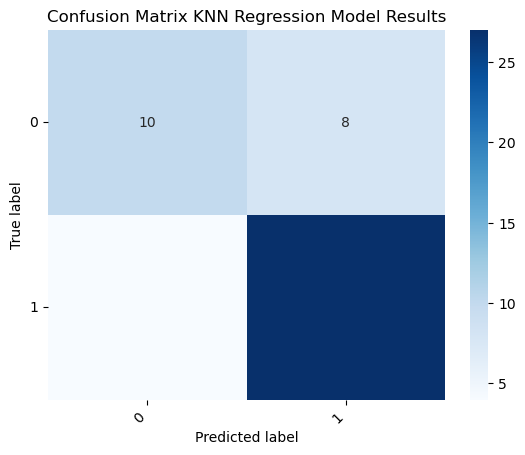

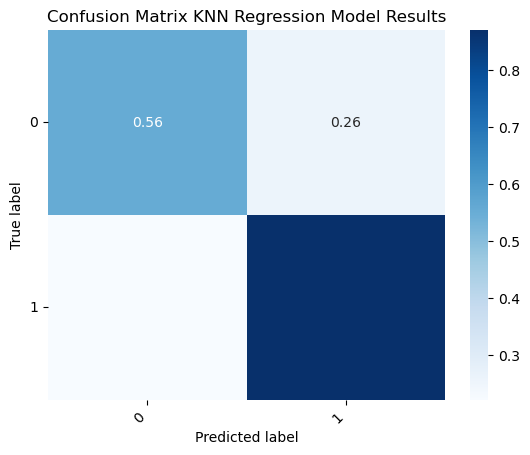

In [7]:
model = GaussianNB()
NB_mod = train_a_model(X, y, 5, 6, model)


---------CLASSIFIER PERFORMANCE-------------------------------

       Classifier score:  0.7959
      Training Accuracy:  0.7959
    Prediciton Accuracy:  0.7959
              Precision:  0.8086
                 Recall:  0.7455
               F1 Score:  0.7598
                  AUROC:  0.7401
               Log Loss:  0.5700269767976537

---------CROSS VALIDATION-------------------------------------

 Cross validated scores:  [0.9    0.7    0.3    0.5    0.6667]
     Mean of CV results:  0.6133
      STD of CV results:  0.2018
    Absolute Mean Error:  0.3867
                   RMSE:  0.6218

---------CLASSIFICATION REPORT--------------------------------


               precision    recall  f1-score   support

           0       0.83      0.56      0.67        18
           1       0.78      0.94      0.85        31

    accuracy                           0.80        49
   macro avg       0.81      0.75      0.76        49
weighted avg       0.80      0.80      0.78        49


----

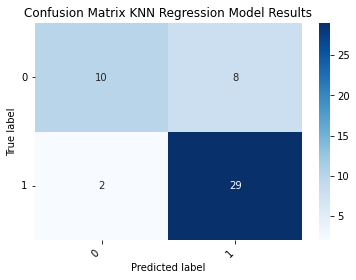

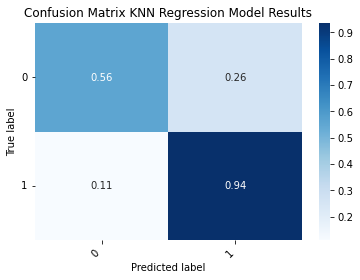

In [6]:
model = XGBClassifier(objective='binary:logistic', random_state = 6, learning_rate=0.2, 
                      max_depth=1, eta = 0.5, gamma = 5, min_child_weight = 2,
                     subsample = 0.5, reg_lambda = 1, reg_alpha = 0)
XGB_mod = train_a_model(X, y, 5, 6, model)


---------CLASSIFIER PERFORMANCE-------------------------------

       Classifier score:  0.6327
      Training Accuracy:  0.6327
    Prediciton Accuracy:  0.6327
              Precision:  0.3163
                 Recall:  0.5
               F1 Score:  0.3875
                  AUROC:  0.5
               Log Loss:  12.687713777722294

---------CROSS VALIDATION-------------------------------------

 Cross validated scores:  [0.7    0.7    0.3    0.6    0.8889]
     Mean of CV results:  0.6378
      STD of CV results:  0.193
    Absolute Mean Error:  0.3622
                   RMSE:  0.6018

---------CLASSIFICATION REPORT--------------------------------


               precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.63      1.00      0.78        31

    accuracy                           0.63        49
   macro avg       0.32      0.50      0.39        49
weighted avg       0.40      0.63      0.49        49


---------CO

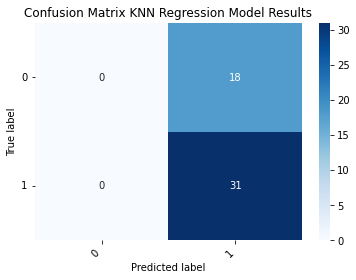

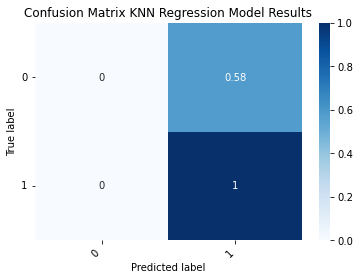

In [7]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, activation = 'identity', learning_rate = 'constant',
                    hidden_layer_sizes=(10, 2), random_state = 6)
MLP_mod = train_a_model(X, y, 5, 6, model)


---------CLASSIFIER PERFORMANCE-------------------------------

       Classifier score:  0.6531
      Training Accuracy:  0.6531
    Prediciton Accuracy:  0.6531
              Precision:  0.6241
                 Recall:  0.621
               F1 Score:  0.6222
                  AUROC:  0.7025
               Log Loss:  3.315693308066127

---------CROSS VALIDATION-------------------------------------

 Cross validated scores:  [0.9    0.8    0.6    0.6    0.6667]
     Mean of CV results:  0.7133
      STD of CV results:  0.1185
    Absolute Mean Error:  0.2867
                   RMSE:  0.5354

---------CLASSIFICATION REPORT--------------------------------


               precision    recall  f1-score   support

           0       0.53      0.50      0.51        18
           1       0.72      0.74      0.73        31

    accuracy                           0.65        49
   macro avg       0.62      0.62      0.62        49
weighted avg       0.65      0.65      0.65        49


------

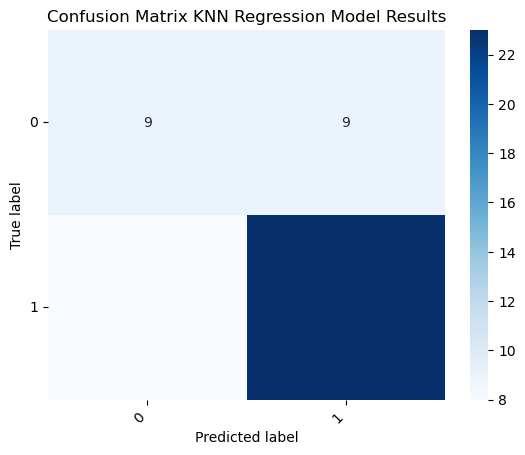

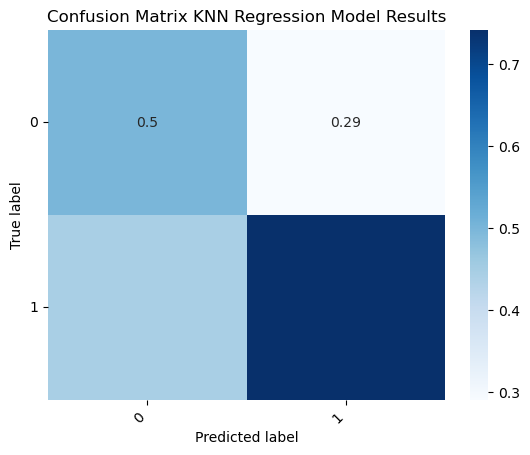

In [8]:
model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
KNN_mod = train_a_model(X, y, 5, 6, model)

In [9]:
#SVM doesn't have probabilities, so the funciton won't work for it
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6,  test_size=0.2)

model = svm.SVC(kernel = 'linear', )
model.fit(X_train, y_train)
predictions = model.predict(X_test)

accuracy = model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Classification
print(classification_report(y_test, predictions))

#set the Kfold
kf = KFold(n_splits = 5, random_state=6, shuffle = True) 
#do the cross validation
scores = cross_val_score(model, X_test, y_test, cv=kf, scoring='accuracy', n_jobs = -1)
#view mean absolute error
MSEscores = cross_val_score(model, X_test, y_test, scoring='neg_mean_absolute_error', cv=kf)
MSE = np.round(abs(MSEscores.mean()),4)
#view RMSE
RMSEscores = cross_val_score(model, X_test, y_test, scoring='neg_mean_squared_error',cv=kf)
RMSE = np.round(np.sqrt(abs(RMSEscores.mean())),4)

conmat = confusion_matrix(y_test, predictions)
val = np.mat(conmat) 
classnames = list(set(y_train))
df_cm = pd.DataFrame(val, index=classnames, columns=classnames)
print(df_cm)

Accuracy: 75.51%
              precision    recall  f1-score   support

           0       0.75      0.50      0.60        18
           1       0.76      0.90      0.82        31

    accuracy                           0.76        49
   macro avg       0.75      0.70      0.71        49
weighted avg       0.75      0.76      0.74        49

   0   1
0  9   9
1  3  28


# Hyper Tuning XGBoost model

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6,  test_size=0.2)

In [11]:
hyper_params={'n_estimators': 180,
              'max_depth': hp.quniform("max_depth", 0, 18, 1),
              'max_delta_step':hp.quniform('max_delta_step', 0,180,1),
              'max_leaves': hp.quniform('max_leaves', 0,180,1),
              'learning_rate':hp.uniform('learning_rate', 0.01,1),
              'eta':hp.uniform('eta', 0.01,1),
              'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
              'subsample':hp.uniform ('subsample', 0.5,1),
              'gamma': hp.uniform ('gamma', 0,9),
              'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
              'reg_lambda' : hp.uniform('reg_lambda', 0,1),
              'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
              'seed': 0
             }

In [12]:
def HP_tuning(hyper_params):
    model=XGBClassifier(objective='binary:logistic',
                       grow_policy = 'lossguide',
                       random_state = 6,
                       learning_rate = hyper_params['learning_rate'],
                       max_depth = int(hyper_params['max_depth']),
                       max_delta_step = hyper_params['max_delta_step'],
                       max_leaves = int(hyper_params['max_leaves']),
                       eta = hyper_params['eta'],
                       min_child_weight = int(hyper_params['min_child_weight']),
                       subsample = hyper_params['subsample'],
                       gamma = hyper_params['gamma'],
                       reg_lambda = hyper_params['reg_lambda'],
                       #reg_alpha = int(hyper_params['reg_alpha']),
                       colsample_bytree= int(hyper_params['colsample_bytree']),
                       n_estimators = hyper_params['n_estimators']
                      )
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,)
          #  eval_set=evaluation, eval_metric="auc",
          #  early_stopping_rounds=30,verbose=False)

    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    #change the metric if you like
    
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

In [13]:
#somewhat random, running this many time can result in slightly differing best scores.
trials = Trials()

best_hyperparams = fmin(fn = HP_tuning,
                        space = hyper_params,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

SCORE:                                                 
0.6938775510204082                                     
SCORE:                                                 
0.7142857142857143                                                                
SCORE:                                                                            
0.7142857142857143                                                                
SCORE:                                                                            
0.6938775510204082                                                                
SCORE:                                                                            
0.7551020408163265                                                                
SCORE:                                                                            
0.7551020408163265                                                                
SCORE:                                                                            
0.

In [14]:
loss = trials.best_trial['result']['loss']
print ('loss :', loss)
rugby_model = trials.best_trial['result']['model']
print (rugby_model)

loss : -0.7959183673469388
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eta=0.5619707245469561, eval_metric=None, feature_types=None,
              gamma=2.4303833865261866, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03240226568629434, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=101.0, max_depth=17, max_leaves=60,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, ...)



---------CLASSIFIER PERFORMANCE-------------------------------

       Classifier score:  0.7959
      Training Accuracy:  0.7959
    Prediciton Accuracy:  0.7959
              Precision:  0.8086
                 Recall:  0.7455
               F1 Score:  0.7598
                  AUROC:  0.7446
               Log Loss:  0.5571615018485565

---------CROSS VALIDATION-------------------------------------

 Cross validated scores:  [0.7    0.7    0.3    0.6    0.6667]
     Mean of CV results:  0.5933
      STD of CV results:  0.1511
    Absolute Mean Error:  0.4067
                   RMSE:  0.6377

---------CLASSIFICATION REPORT--------------------------------


               precision    recall  f1-score   support

           0       0.83      0.56      0.67        18
           1       0.78      0.94      0.85        31

    accuracy                           0.80        49
   macro avg       0.81      0.75      0.76        49
weighted avg       0.80      0.80      0.78        49


----

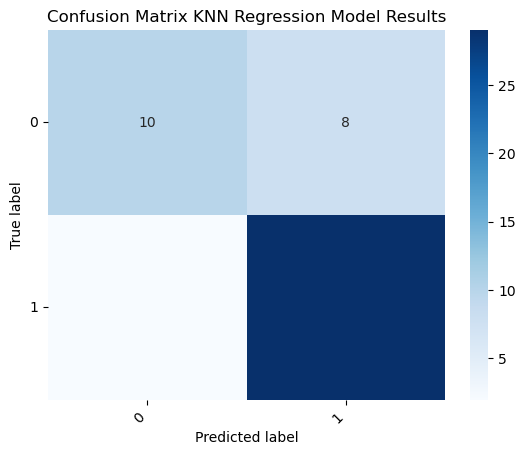

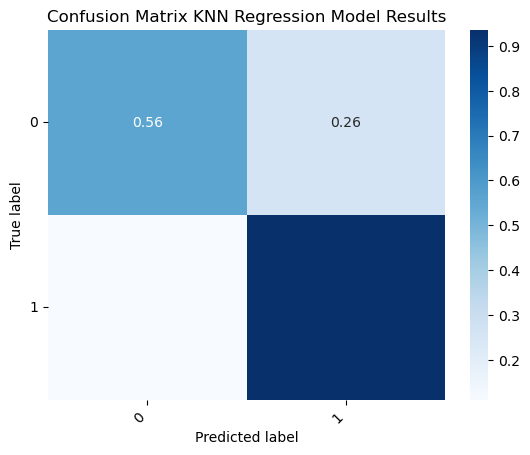

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eta=0.5619707245469561, eval_metric=None, feature_types=None,
              gamma=2.4303833865261866, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03240226568629434, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=101.0, max_depth=17, max_leaves=60,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, ...)

In [15]:
#Getting themodel performance
train_a_model(X, y, 5, 6, rugby_model)

# The best model for prediction is the XGB model 
## Export this model

In [16]:
filename = 'rugby_model.sav'
joblib.dump(XGB_mod, filename)

NameError: name 'XGB_mod' is not defined

# Testing the Model: Select Teams and use the model to predict

In [1]:
def select_team(df, home, away, model):
    home_team_df = df[df['name'].isin(home)].reset_index()
    away_team_df = df[df['name'].isin(away)].reset_index()
    
    home_team = home_team_df.iloc[:, 3:6]
    home_team.columns = {'home_ability_score', 'home_attack_score', 'home_defend_score'}
    
    away_team = away_team_df.iloc[:, 3:6]
    away_team.columns = {'away_ability_score', 'away_attack_score', 'away_defend_score'}
    
    teams_df = pd.concat([home_team, away_team], axis = 1)
    teams_df = pd.DataFrame(teams_df.sum(axis=0)).T
    
    #turn into array for model
    team_arr = np.asarray(teams_df)
    team_data = team_arr.reshape(1, 6)
    
    # print(model.predict(team_data))
    # print(model.predict_proba(team_data))
    print(model.predict(team_data))
    print(model.predict_proba(team_data))
    return model.predict(team_data), model.predict_pro(team_data)
   

In [2]:
#this is a real line up for a game player on the 17th of May between the Hurricanes (home) and Moana Pasifika (away) in which the Hurricanes won. This match is not in the data used on the model
home_team = ['Pouri Rakete-Stones', 'Raymond Tuputupu', 'Siale Lauaki', 'Justin Sangster', 
             'Ben Grant', 'Brad Shields', "Du'Plessis Kirifi", 'Devan Flanders',
            'Richard Judd', 'Aidan Morgan', 'Kini Naholo', 'Peter Umaga-Jensen',
            'Bailyn Sullivan','Dan Sinkinson', 'Harry Godfrey', "James O'Reilly",
            'Xavier Numia', 'Pasilio Tosi', 'Isaia Walker-Leawere', 'Peter Lakai',
            'Jordi Viljoen', 'Riley Higgins', 'Salesi Rayasi']

away_team = ['Abraham Pole', 'Samiuela Moli', 'Sione Mafileo', 'Tom Savage', 'Allan Craig',
             'Jacob Norris', 'Sione Havili Talitui', 'Fine Inisi', 'Lotu Inisi', 'Jonathan Taumateine',
             'William Havili', 'Neria Fomai', 'Julian Savea', 'Pepesana Patafilo', 'Danny Toala',
             'Sama Malolo', 'Ola Tauelangi',  'Sekope Kepu', 'Samuel Slade', 'Alamanda Motuga',
             'Aisea Halo', "Christian Leali'ifano", 'Anzelo Tuitavuki']

In [19]:
select_team(player_ability, home_team, away_team, rugby_model)

[1]
[[0.36691648 0.6330835 ]]


In [4]:
import joblib

In [5]:
filename = 'rugby_model.sav'
loaded_model = joblib.load(filename)

In [10]:
import pandas as pd
import numpy as np

In [11]:
match_df = pd.read_csv('match_df.csv').iloc[:, 1:]
player_ability = pd.read_csv('ranked_player_data.csv').iloc[:, 1:]

In [13]:
select_team(player_ability, home_team, away_team, loaded_model)

[1]
[[0.47562367 0.52437633]]


TypeError: 'NoneType' object is not subscriptable